### Import modules 

In [70]:
# numpy stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras callbacks
# from keras.layers import Input, Dense
# from keras.models import Model, load_model
# from keras import optimizers
from keras.callbacks import *

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense
from tensorflow.keras import optimizers
from keras.models import Model, load_model
from keras.layers import Input, Dense, Layer, InputSpec
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, activations, initializers, constraints, Sequential
from keras import backend as K
from keras.constraints import UnitNorm, Constraint
from sklearn.metrics import mean_squared_error

# json
import json

# other
import time


# AutoEncoders for Event Detection (AEED)
# from aeed import AEED, load_AEED

### Class

In [71]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

In [72]:
class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis

    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = K.transpose(w)
        if(self.encoding_dim > 1):
            m = K.dot(K.transpose(w), w) - K.eye(self.encoding_dim)
            return self.weightage * K.sqrt(K.sum(K.square(m)))
        else:
            m = K.sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)

In [73]:
# classes
class AutoEncoder(object):
    """ Keras-based AutoEncoder (AE) class used for event detection.

        Attributes:
        params: dictionary with parameters defining the AE structure,
    """
    def __init__(self, **kwargs):
        """ Class constructor, stores parameters and initialize AE Keras model. """

        # Default parameters values. If nI is not given, the code will crash later.
        params = {
            'nI': None,
            'nH': 3,
            'cf': 1,
            'activation' : 'tanh',
            'optimizer' : None,
            'verbose' : 0
            }

        for key,item in kwargs.items():
            params[key] = item

        self.params = params

    def create_model(self):
        """ Creates Keras AE model.

            The model has nI inputs, nH hidden layers in the encoder (and decoder)
            and cf compression factor. The compression factor is the ratio between
            the number of inputs and the innermost hidden layer which stands between
            the encoder and the decoder. The size of the hidden layers between the
            input (output) layer and the innermost layer decreases (increase) linearly
            according to the cg.
        """

        # retrieve params
        nI = self.params['nI'] # number of inputs
        nH = self.params['nH'] # number of hidden layers in encoder (decoder)
        cf = self.params['cf'] # compression factor
        activation = self.params['activation'] # autoencoder activation function
        optimizer = self.params['optimizer'] # Keras optimizer
        verbose = self.params['verbose'] # echo on screen

        # get number/size of hidden layers for encoder and decoder
        temp = np.linspace(nI,nI/cf,nH + 1).astype(int)
        nH_enc = temp[1:]
        nH_dec = temp[:-1][::-1]

        # input layer placeholder
        input_layer = Input(shape=(nI,))

        # build encoder
        for i, layer_size in enumerate(nH_enc):
            if i == 0:
                # first hidden layer
                encoder = Dense(layer_size, activation=activation,use_bias=True)(input_layer)
            else:
                # other hidden layers
                encoder = Dense(layer_size, activation=activation,use_bias=True)(encoder)

        # build decoder
        for i, layer_size in enumerate(nH_dec):
            if i == 0:
                # first hidden layer
                decoder = DenseTied(layer_size, activation=activation,use_bias=True)(encoder)
            else:
                # other hidden layers
                decoder = DenseTied(layer_size, activation=activation,use_bias=True)(decoder)

        # create autoencoder
        autoencoder = Model(input_layer, decoder)
        if optimizer == None:
            optimizer = optimizers.Adam(learning_rate = 0.001)

        # print autoencoder specs
        if verbose > 0:
            print('Created autoencoder with structure:');
            print(', '.join('layer_{}: {}'.format(v, i) for v, i in enumerate(np.hstack([nI,nH_enc,nH_dec]))))

        # compile and return model
        autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
        return autoencoder

    def train(self, x, **train_params):
        """ Train autoencoder,

            x: inputs (inputs == targets, AE are self-supervised ANN).
        """
        if self.params['verbose']:
            if self.ann == None:
                print('Creating model.')
                self.create_model()
        self.ann.fit(x, x, **train_params)


    def predict(self, x, test_params={}):
        """ Yields reconstruction error for all inputs,

            x: inputs.
        """
        return self.ann.predict(x, **test_params)

class AEED(AutoEncoder):
    """ This class extends the AutoEncoder class to include event detection
        functionalities.
    """
    def initialize(self):
        """ Create the underlying Keras model. """
        self.ann = self.create_model()

    def predict(self, x, **keras_params):
        """ Predict with autoencoder. """
        preds = pd.DataFrame(index=x.index,columns=x.columns,
                                            data=super(AEED, self).predict(x.values,keras_params))
        errors = (x-preds)**2
        return preds, errors

    def detect(self, x, theta, window = 12, average=True, sys_theta = 0, **keras_params):
        """ Detection performed based on (smoothed) reconstruction errors.

            x = inputs,
            theta = threshold, attack flagged if reconstruction error > threshold,
            window = length of the smoothing window (default = 1 timestep, i.e. no smoothing),
            average = boolean (default = False), if True the detection is performed
                on the average reconstruction error across all outputs,
            keras_params = parameters for the Keras-based AE prediction.
        """
        #        preds = super(AEED, self).predict(x,keras_params)
        preds, temp = self.predict(x, **keras_params)
        temp = (x-preds)**2
        if average:
            errors = temp.mean(axis=1).rolling(window=window).mean()
            detection = errors > theta
        else:
            # errors = temp.rolling(window=window).mean()
            errors = temp.ewm(alpha=0.003, adjust=False).mean()
            detection = errors.apply(lambda x: x>np.max(theta.name, sys_theta))

        return detection, errors

    def save(self, filename):
        """ Save AEED model.

            AEED parameters saved in a .json, while Keras model is stored in .h5 .
        """
        # parameters
        with open(filename+'.json', 'w') as fp:
            json.dump(self.params, fp)
        # keras model
        self.ann.save(filename+'.h5')
        # echo
        print('Saved AEED parameters to {0}.\nKeras model saved to {1}'.format(filename+'.json', filename+'.h5'))


# functions
def load_AEED(params_filename, model_filename):
    """ Load stored AEED. """
    # load params and create AEED
    with open(params_filename) as fd:
        params = json.load(fd)
    aeed = AEED(**params)

    # load keras model
    aeed.ann = load_model(model_filename)
    return aeed


### Load and preprocess training data

In [74]:
# load training dataset
data_path = "./data/"
df_train_orig = pd.read_csv(data_path + "dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [75]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)

### Train autoencoder

In [76]:
# define model parameters
params = {
    'nI' : X.shape[1],
    'nH' : 3,
    'cf' : 2.5,
    'activation' : 'tanh',
    'verbose' : 1,
}

# create AutoEncoder for Event Detection (AEED)
autoencoder = AEED(**params)
autoencoder.initialize()

Created autoencoder with structure:
layer_0: 43, layer_1: 32, layer_2: 22, layer_3: 12, layer_4: 22, layer_5: 32, layer_6: 43


In [77]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')
    
# initialize time
start_time = time.time()

# train autoencoder
autoencoder.train(X1.values,
            epochs=500,
            batch_size=32,
            shuffle=False,
            callbacks = [earlyStopping, lr_reduced],
            verbose = 2,
            validation_data=(X2.values, X2.values))



Epoch 1/500
184/184 - 1s - loss: 0.0814 - val_loss: 0.0341
Epoch 2/500
184/184 - 0s - loss: 0.0228 - val_loss: 0.0157
Epoch 3/500
184/184 - 0s - loss: 0.0137 - val_loss: 0.0105
Epoch 4/500
184/184 - 0s - loss: 0.0099 - val_loss: 0.0086
Epoch 5/500
184/184 - 0s - loss: 0.0082 - val_loss: 0.0075
Epoch 6/500
184/184 - 0s - loss: 0.0074 - val_loss: 0.0070
Epoch 7/500
184/184 - 0s - loss: 0.0070 - val_loss: 0.0065
Epoch 8/500
184/184 - 0s - loss: 0.0066 - val_loss: 0.0062
Epoch 9/500
184/184 - 0s - loss: 0.0061 - val_loss: 0.0056
Epoch 10/500
184/184 - 0s - loss: 0.0052 - val_loss: 0.0045
Epoch 11/500
184/184 - 0s - loss: 0.0041 - val_loss: 0.0036
Epoch 12/500
184/184 - 0s - loss: 0.0034 - val_loss: 0.0030
Epoch 13/500
184/184 - 0s - loss: 0.0029 - val_loss: 0.0027
Epoch 14/500
184/184 - 0s - loss: 0.0027 - val_loss: 0.0025
Epoch 15/500
184/184 - 0s - loss: 0.0025 - val_loss: 0.0024
Epoch 16/500
184/184 - 0s - loss: 0.0024 - val_loss: 0.0023
Epoch 17/500
184/184 - 0s - loss: 0.0023 - val_lo

### Test autoencoder

In [78]:
# assess detection
def compute_scores(Y,Yhat):
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall_score(Y,Yhat)]

In [79]:
# Load dataset with attacks
df_test_01 = pd.read_csv(data_path + "dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv(data_path + "test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

# scale datasets
X3 = pd.DataFrame(index = df_test_01.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))
X4 = pd.DataFrame(index = df_test_02.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))

# get targets
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']

/Users/nazmul/opt/anaconda3/envs/aeed-master/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


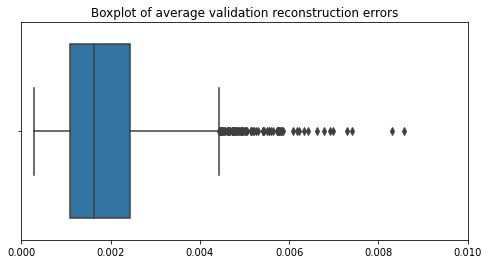

In [80]:
# perform detection

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(X2)
#validation_errors.ewm(alpha=0.003, adjust=False).mean()
# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.01])

ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta = validation_errors.mean(axis = 1).quantile(0.985)

Yhat3, _ = autoencoder.detect(X3, theta = theta , window = 12, average=True)
Yhat4, _ = autoencoder.detect(X4, theta = theta, window = 12, average=True)

In [81]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall'])
results.loc['test dataset 01'] = compute_scores(Y3,Yhat3)
results.loc['test dataset 02'] = compute_scores(Y4,Yhat4)

print('Results:\n')
print(results)

Results:

                 accuracy  f1_score precision    recall
test dataset 01  0.946852  0.757112  0.819905  0.703252
test dataset 02  0.935376  0.821192  0.890805  0.761671


[Text(0, 0, 'NO ATTACK'), Text(0, 1, 'ATTACK')]

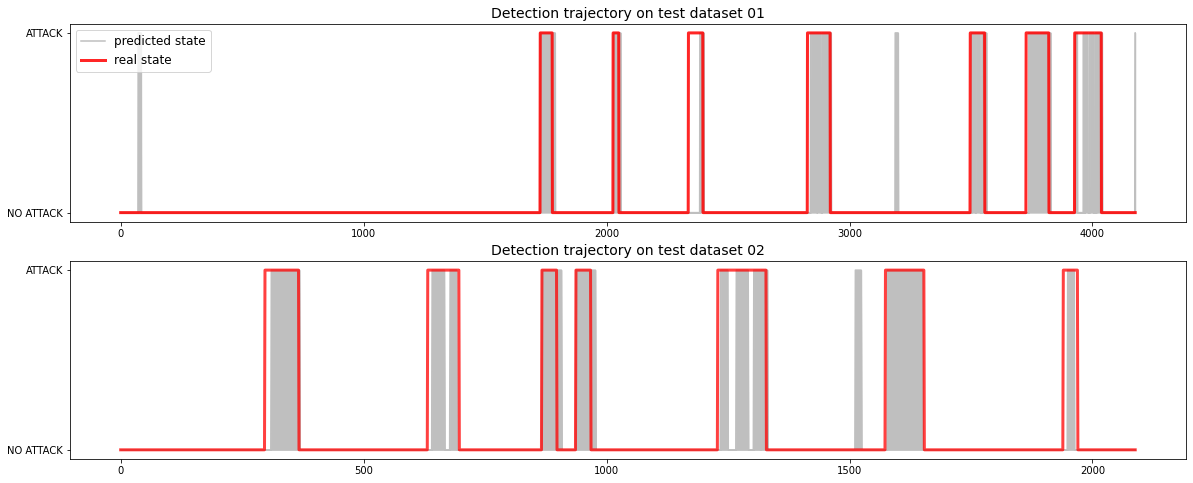

In [82]:
# plot figures
shade_of_gray = '0.75'
f, axes = plt.subplots(2,figsize = (20,8))
axes[0].plot(Yhat3, color = shade_of_gray, label = 'predicted state')
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color=shade_of_gray)
axes[0].plot(Y3, color = 'r', alpha = 0.85, lw = 3, label = 'real state')
axes[0].set_title('Detection trajectory on test dataset 01', fontsize = 14)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'])
axes[0].legend(fontsize = 12, loc = 2)

axes[1].plot(Yhat4, color = shade_of_gray, label = 'predicted state')
axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color=shade_of_gray)
axes[1].plot(Y4, color = 'r', alpha = 0.75, lw = 3, label = 'real state')
axes[1].set_title('Detection trajectory on test dataset 02', fontsize = 14)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

In [83]:
# save autoencoder
autoencoder.save('autoencoder')
del autoencoder

/Users/nazmul/opt/anaconda3/envs/aeed-master/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


NotImplementedError: Layer DenseTied has arguments in `__init__` and therefore must override `get_config`.

### Compare ROC curves

In [ ]:
# load autoencoder
autoencoder = load_AEED('autoencoder.json','autoencoder.h5')

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(X2)

In [ ]:
def compute_roc_curve(X, Y, window, quantiles, verbose = False):    
    print('Computing ROC curve for window = %d'%(window))    
    df_roc = pd.DataFrame(index = quantiles, columns = ['fpr','tpr'])
    for qtile in quantiles:
        # compute results
        theta = validation_errors.mean(axis = 1).quantile(qtile)
        if verbose:
            print('Quantile: {0:.3f}, threshold value: {1:.5}'.format(qtile,theta))
        Yhat, _ = autoencoder.detect(X, theta = theta, window = window, average=True)
        CM = confusion_matrix(Y,Yhat)
        TN = CM[0,0]
        FP = CM[0,1]
        FN = CM[1,0]
        TP = CM[1,1]        
        fpr = FP/(FP+TN)
        tpr = TP/(TP+FN) # or recall_score, same stuff
        df_roc.loc[qtile,:] = [fpr, tpr]

    # compute auc
    df_roc.loc[0,:] = (1,1)
    df_roc.loc[1000,:] = (0,0)    
    area = auc(df_roc['fpr'],df_roc['tpr'], reorder =True)
        
    return df_roc.sort_index(), area


In [ ]:
windows = [1,3,6,12]
colors = ['blue', 'green', 'black', 'red']
markers = ['s','o','x','v']

thresholds = np.linspace(0.8,1,51)
f, ax = plt.subplots(1,figsize=(10,10))
for window, color, marker in zip(windows,colors,markers):
    df_roc, area = compute_roc_curve(X3, Y3, window, thresholds)
    ax.plot(df_roc.fpr, df_roc.tpr,color = color, lw = 0, linestyle = None, 
        marker = marker, markersize = 10, markerfacecolor = color, 
            label='Window: {0:d} hours, AUC: {1:.3f}'.format(window,area))
ax.legend(fontsize = 15)